# Comparing SARIMA vs Prophet

Load pre-saved models, evaluate, plot graphs

## Define helper functions

In [98]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import pickle
import matplotlib.image as mpimg

cutoff_train_test = 24

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def make_df(prof,sarima, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)
    pred = sarima.get_prediction(start=0, end=-1)
    fitted_values = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)
    ci.columns = ['sarima_lower', 'sarima_upper']

    fc = sarima.get_forecast(steps=cutoff_train_test)
    forecasted_values = fc.predicted_mean
    fcci = fc.conf_int(alpha=0.05)
    fcci.columns = ['sarima_lower', 'sarima_upper']

    ci = pd.concat([ci, fcci])

    forecast['sarima_pred'] = forecasted_values
    forecast['sarima_pred'] = forecast['sarima_pred'].fillna(fitted_values)
    forecast = pd.concat([forecast, ci], axis=1)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper','sarima_pred','sarima_lower', 'sarima_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def make_prophet_df(prof1 ,prof2, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof1.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof1.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)
    forecast = forecast.rename(columns={'yhat' : 'yhat1','yhat_lower' : 'yhat1_lower', 'yhat_upper' : 'yhat1_upper'})

    future2 = prof2.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future2['Date'] = future2['ds']
    future2.set_index('Date', inplace=True)
    if df_external is not None:
            future2 = prepare_time_series(future2, df[df_external.columns])
    else:
            future2 = prepare_time_series(future2)

    forecast2 = prof2.predict(future2)
    forecast2['Date'] = forecast2['ds']
    forecast2.set_index('Date', inplace=True)
    forecast2 = forecast2.rename(columns={'yhat' : 'yhat2','yhat_lower' : 'yhat2_lower', 'yhat_upper' : 'yhat2_upper'})
    forecast = pd.concat([forecast, forecast2[['yhat2','yhat2_lower','yhat2_upper']]], axis=1)

    viz_df = train_df.join(forecast[['yhat1', 'yhat1_lower','yhat1_upper','yhat2','yhat2_lower', 'yhat2_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def plot_verif(verif, cutoff, ax, title=None, predcol='yhat',lower='yhat_lower', upper='yhat_upper'):
    train = verif[:-cutoff]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train[predcol], color='steelblue', lw=0.5)
    ax.fill_between(train.index, train[lower], train[upper], color='steelblue', alpha=0.3)
    test = verif[-cutoff-1:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test[predcol], color='coral', lw=0.5)
    ax.fill_between(test.index, test[lower], test[upper], color='coral', alpha=0.3)
    ax.axvline(test.index.min(), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    if title is not None: 
        ax.set_title(title, fontsize=16)


def plot_joint_plot(verif, x='yhat', y='y', title=None,cutoff=cutoff_train_test, xlim=[0, 4e7], ylim=[0, 4e7], text_offset=-1e7): 
    train = verif[:-cutoff]
    test = verif[-cutoff-1:]

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", scatter=False)
    sns.scatterplot(x=x, y=y, data=train, color='blue', ax=g.ax_joint, label='train set')
    sns.scatterplot(x=x, y=y, data=test, color='red', ax=g.ax_joint, label='test set')
    g.ax_joint.axline((0, 0), slope=1, color='green',linestyle="--", label="ideal match line")
    g.ax_joint.legend()
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    ax = g.fig.axes[1]
    ax.set_xlim(xlim)

    if title is not None: 
        ax.set_title(title, fontsize=16)
    ax = g.fig.axes[0]
    ax.text(1e6, text_offset, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,[y,x]].corr().iloc[0,1], mean_absolute_error(verif.loc[:,y].values, verif.loc[:,x].values)), fontsize=16)
    ax.set_xlabel("model's estimates", fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_ylim(ylim)

    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
    ax.grid(ls=':')
    return g

def plot_comparative(viz_df, pred1='yhat', pred1_lower='yhat_lower',pred1_upper='yhat_upper',pred2='sarima_pred',pred2_lower='sarima_lower',pred2_upper='sarima_upper', title1="Prophet prediction", title2="SARIMA prediction", text_offset=0):
    f, axes = plt.subplots(2, 2, figsize=(20, 16), gridspec_kw={'width_ratios': [8, 2]})
    prof_residuals = viz_df['Sales'] - viz_df[pred1]
    sarima_residuals = viz_df['Sales'] - viz_df[pred2]

    prof_range = [viz_df[pred1].min(),viz_df[pred1].max()]
    data_range = [viz_df['Sales'].min(),viz_df['Sales'].max()]
    sarima_range = [viz_df[pred2].min(),viz_df[pred2].max()]
    pred_range = [min(prof_range[0], sarima_range[0]), max(prof_range[1], sarima_range[1])]
    plot_verif(viz_df, cutoff_train_test, axes[0, 0], title=title1, predcol=pred1, lower=pred1_lower, upper=pred1_upper)
    plot_verif(viz_df, cutoff_train_test, axes[1, 0], title=title2, predcol=pred2, lower=pred2_lower, upper=pred2_upper)
    prof_residuals.hist(bins=7, ax=axes[0,1])
    sarima_residuals.hist(bins=7, ax=axes[1,1])
    axes[0,1].set_title("Prophet residuals")
    axes[1,1].set_title("SARIMA residuals")
    plt.tight_layout()
    jg1 = plot_joint_plot(viz_df, x=pred1, title=title1, xlim=pred_range, ylim=data_range, text_offset=text_offset)
    jg2 = plot_joint_plot(viz_df, x=pred2, title=title2, xlim=pred_range, ylim=data_range, text_offset=text_offset)

    jg1.savefig('jg1.png', dpi=200)
    plt.close(jg1.fig)

    jg2.savefig('jg2.png', dpi=200)
    plt.close(jg2.fig)
    f, axarr = plt.subplots(1, 2, figsize=(14, 10))

    axarr[0].imshow(mpimg.imread('jg1.png'))
    axarr[1].imshow(mpimg.imread('jg2.png'))

    # turn off x and y axis
    [ax.set_axis_off() for ax in axarr.ravel()]
    plt.tight_layout()


## Evaluate total sales

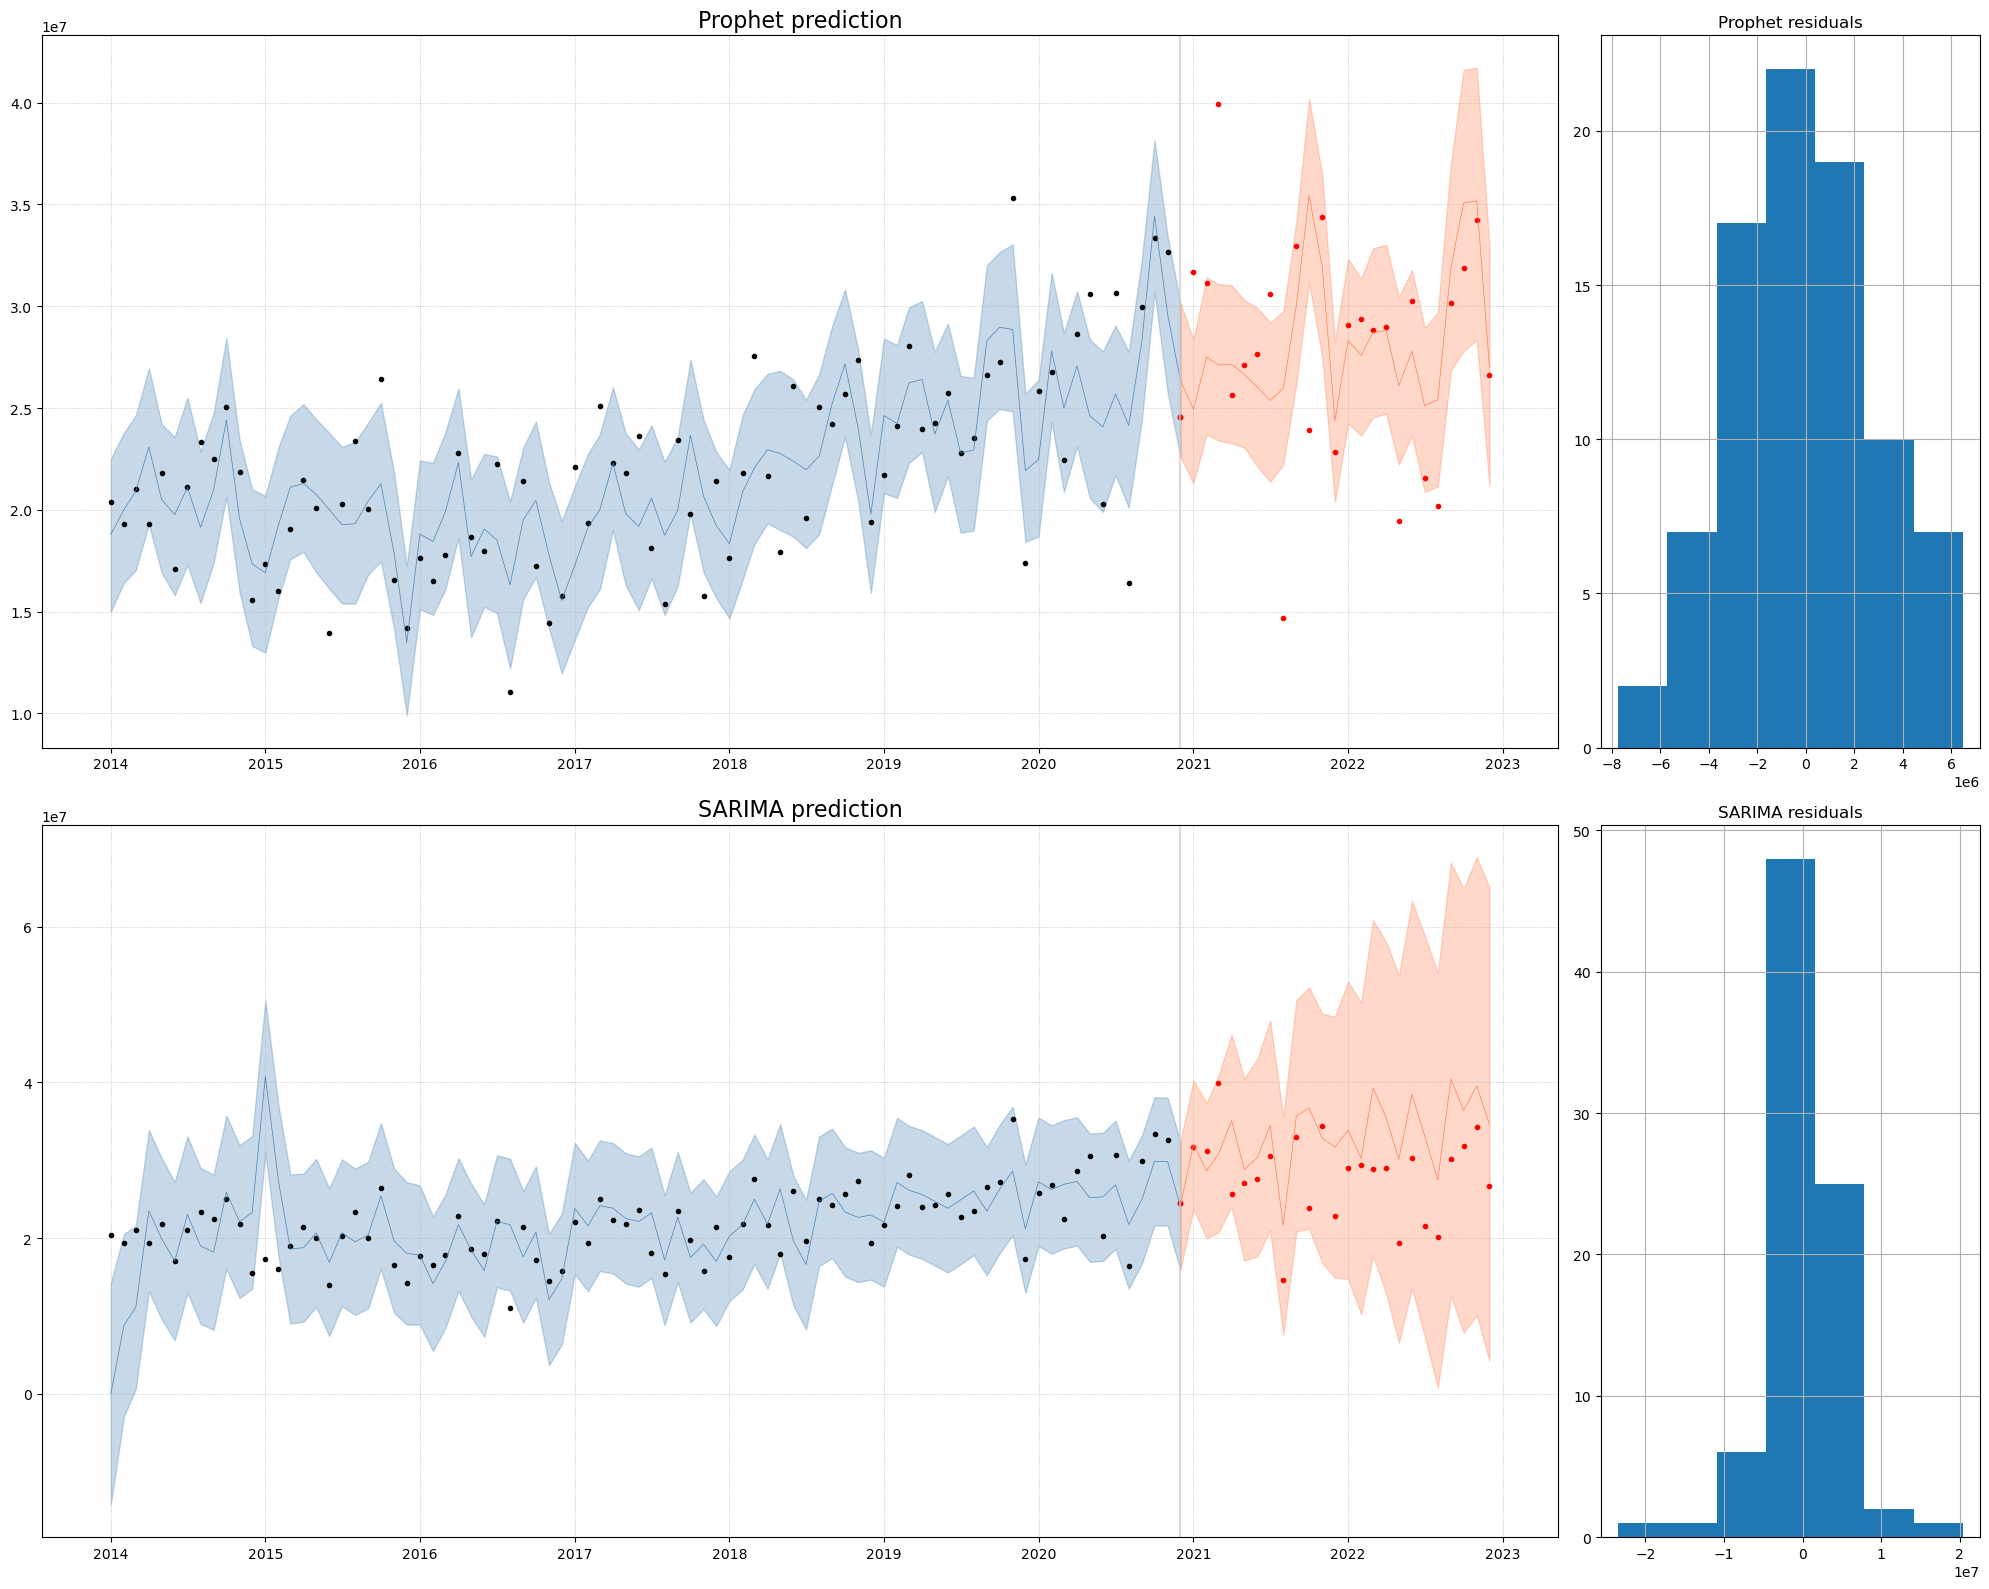

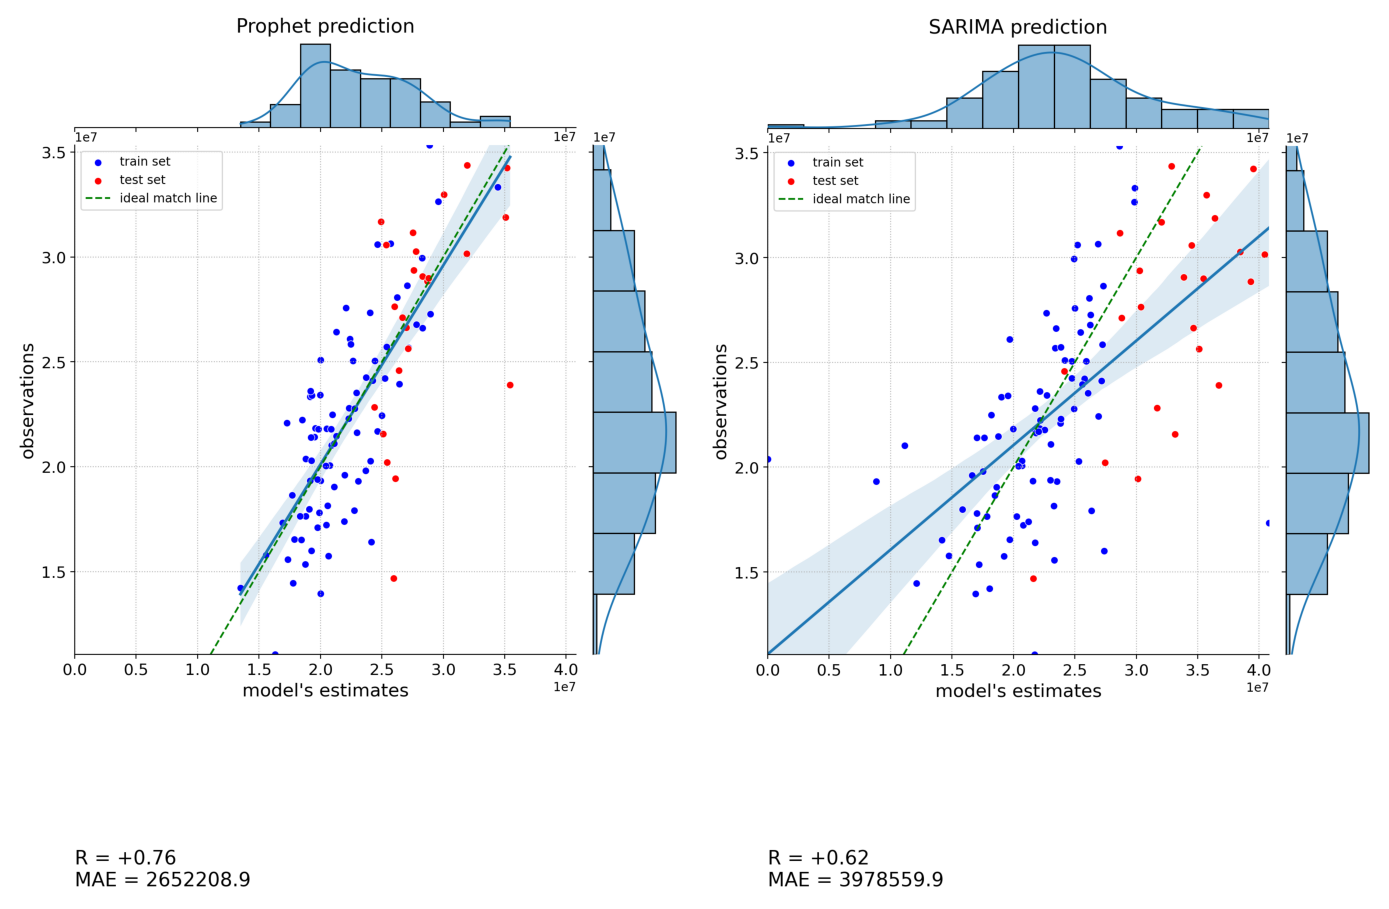

In [77]:
sarima_model = pickle.load(open('sarima.model', 'rb'))
prophet_model = pickle.load(open('prof.model', 'rb'))

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]
viz_df = make_df(prophet_model, sarima_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df)


## Evaluate partial sales (neurology_anestesthesia)

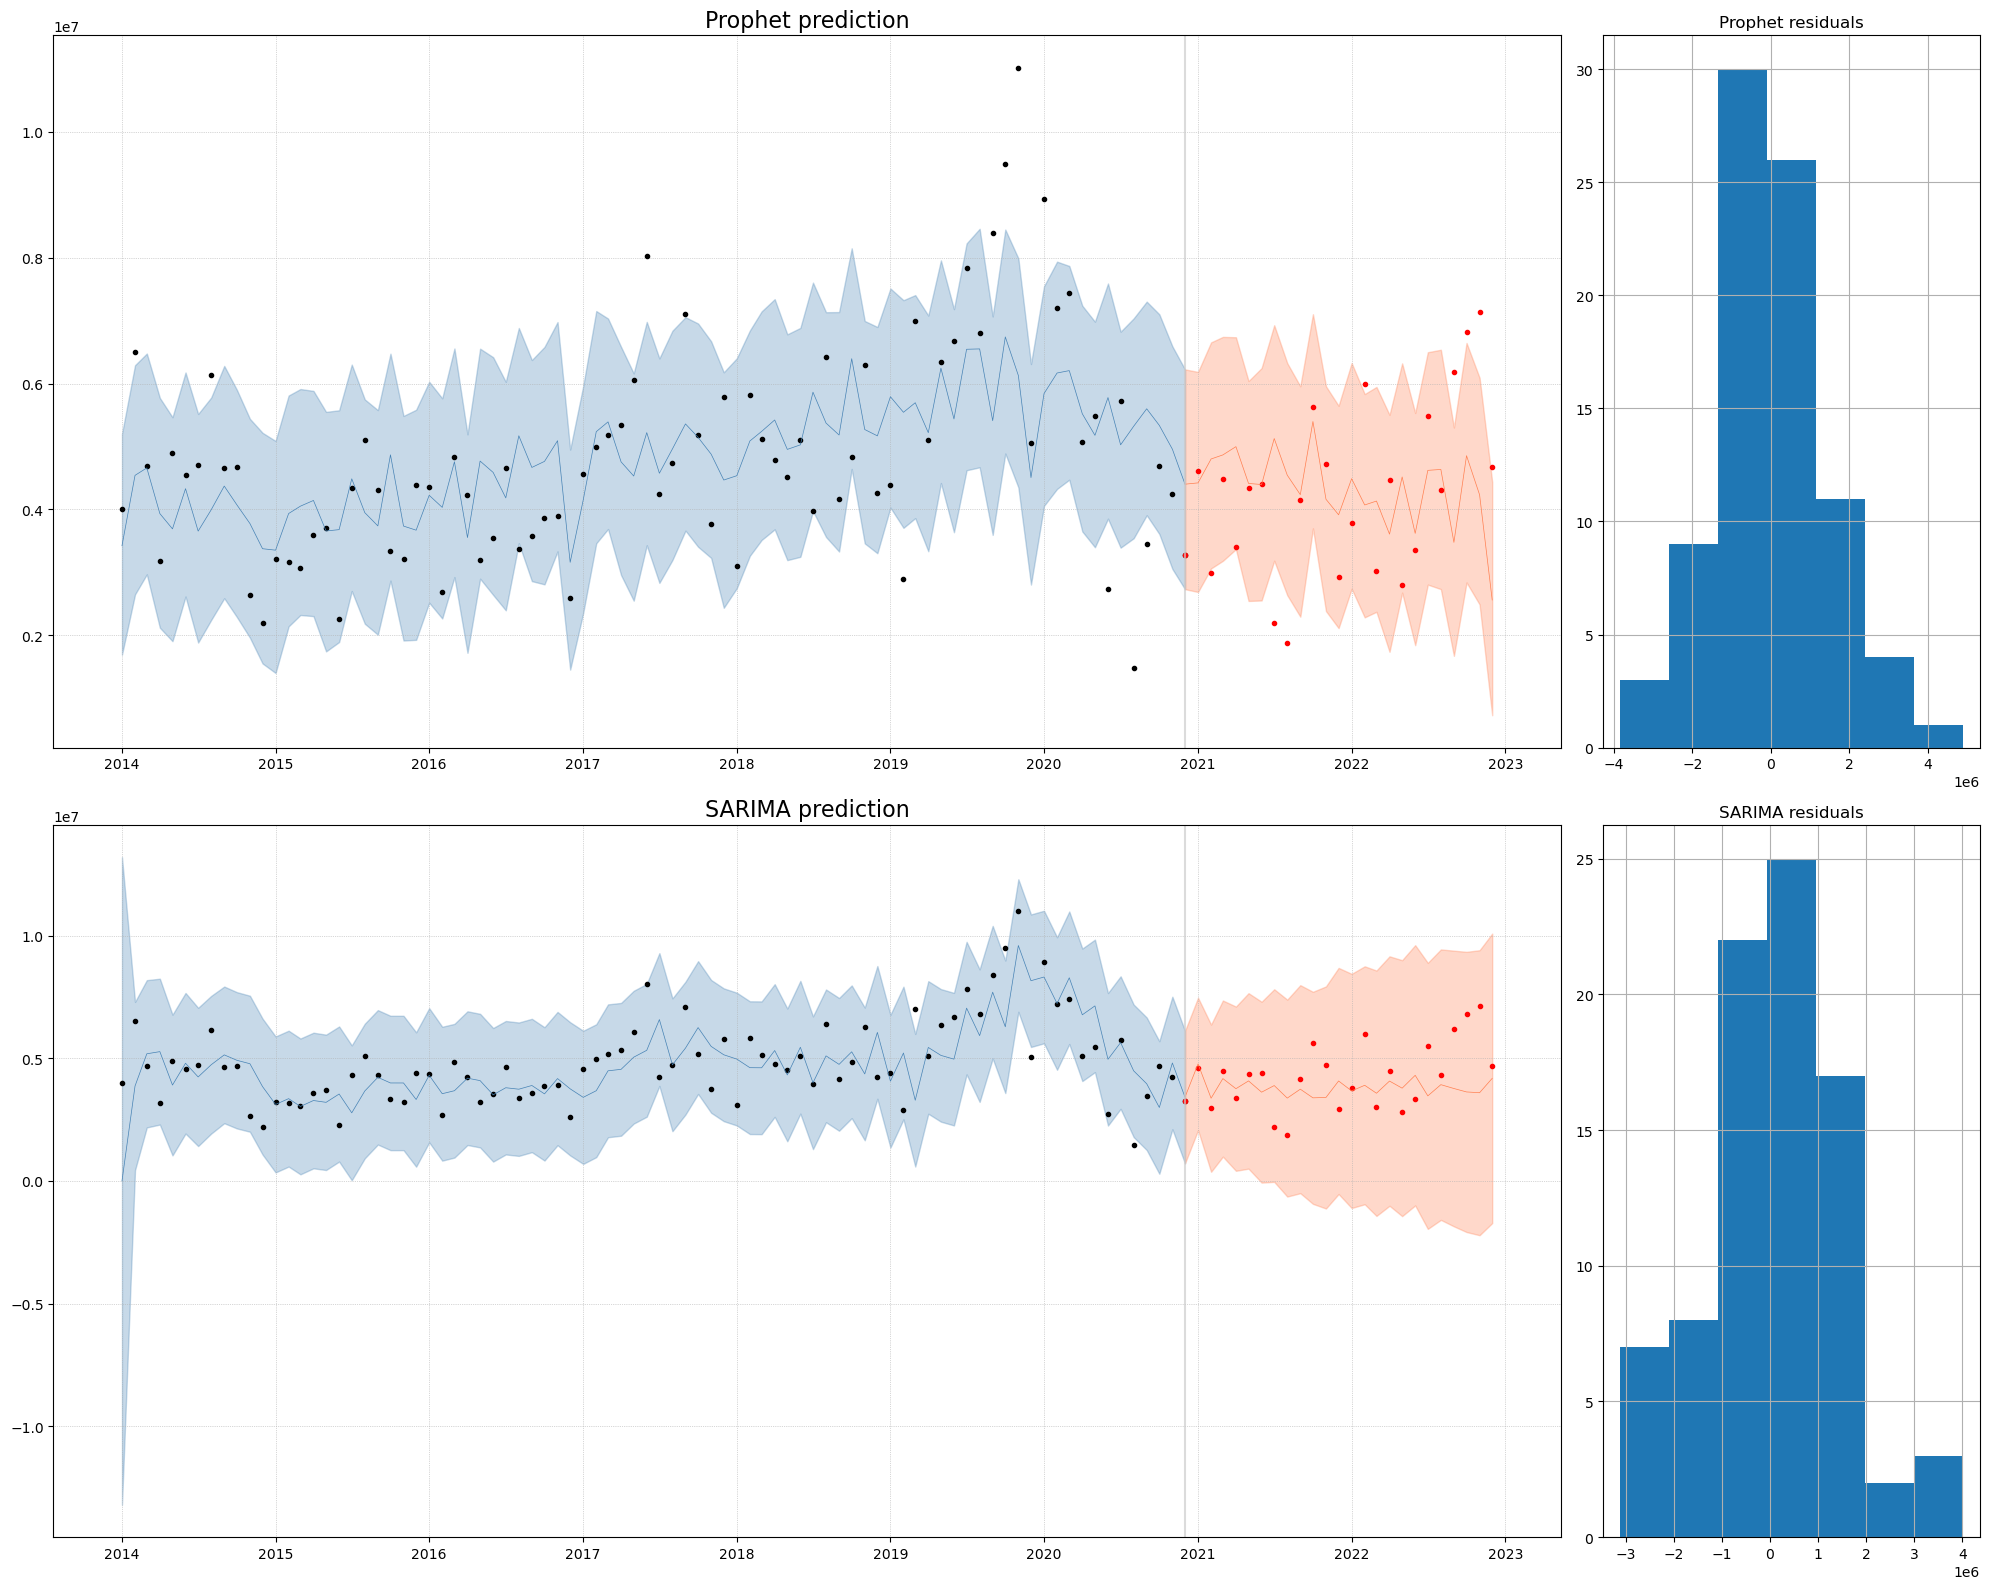

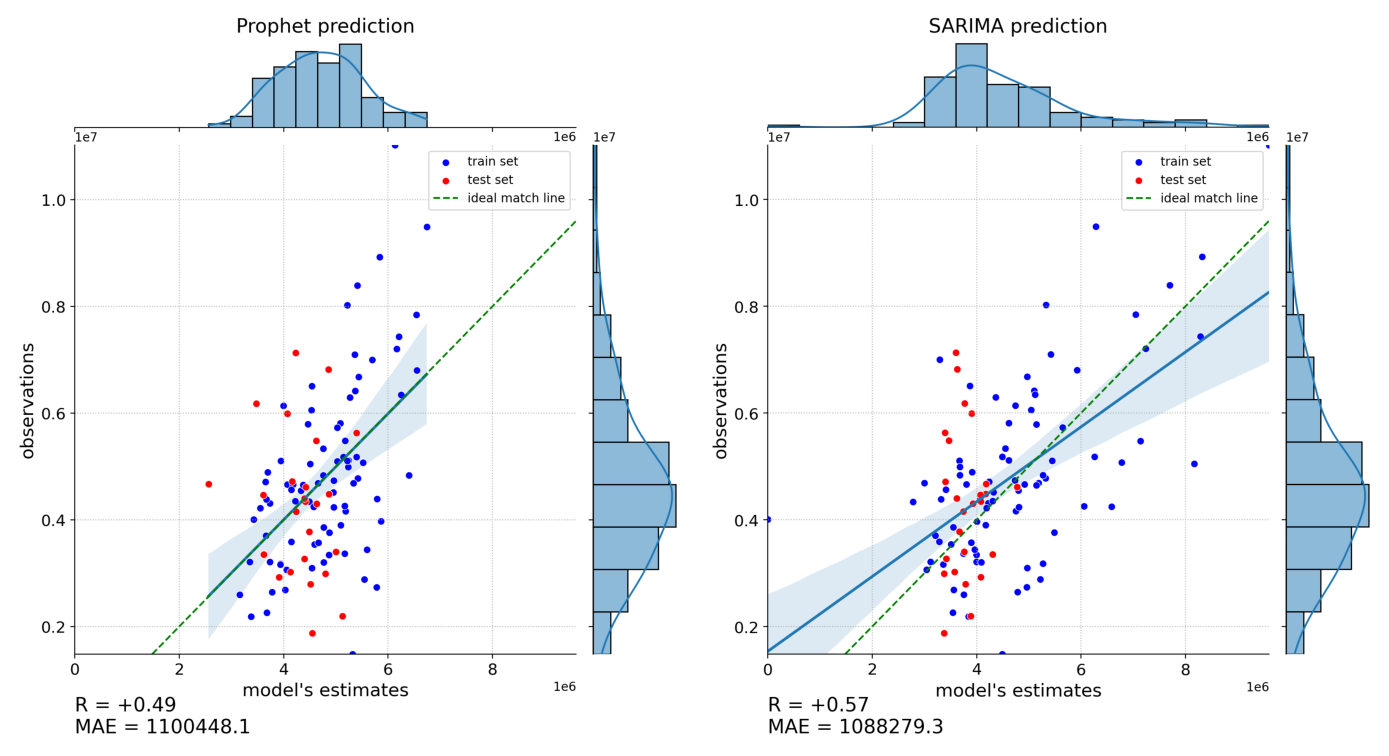

In [78]:
sarima_model = pickle.load(open('sarima_neurology_anestesthesia.model', 'rb'))
prophet_model = pickle.load(open('prof_neurology_anestesthesia.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,F").set_index('Date')
df_sales= df_sales.rename(columns={'neurology_anestesthesia' : 'Sales'})
df_sales.index = pd.to_datetime(df_sales.index)
df_vaccines = pd.read_csv("anesthesia.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

viz_df = make_df(prophet_model, sarima_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df)


## Why does adding regressors help?

Using `explore_which_regressors_improve_which_ts_component.py` I determine the components of my time series on which my vaccine rates has the biggest impact.
I plot the difference of RMSE between the Prophet model which doesn't include the vaccine extenral regressor and the same model that includes it. This way I can easily visualize which component of my sales time series is the most positively and negatively affected (see bar chart).

In [ ]:
import matplotlib.pyplot as plt
from explore_which_regressors_improve_which_ts_component import get_rmse_per_category

df_sales_all = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,F,G,I,J,K,L,M").set_index('Date')
df_sales_all.index = pd.to_datetime(df_sales.index)

col_categories = get_rmse_per_category(cutoff_train_test, df_sales_all, df_vaccines)

Text(0.5, 1.0, 'Improvement of RMSE by adding vaccine as an external regressor (bigger is better)')

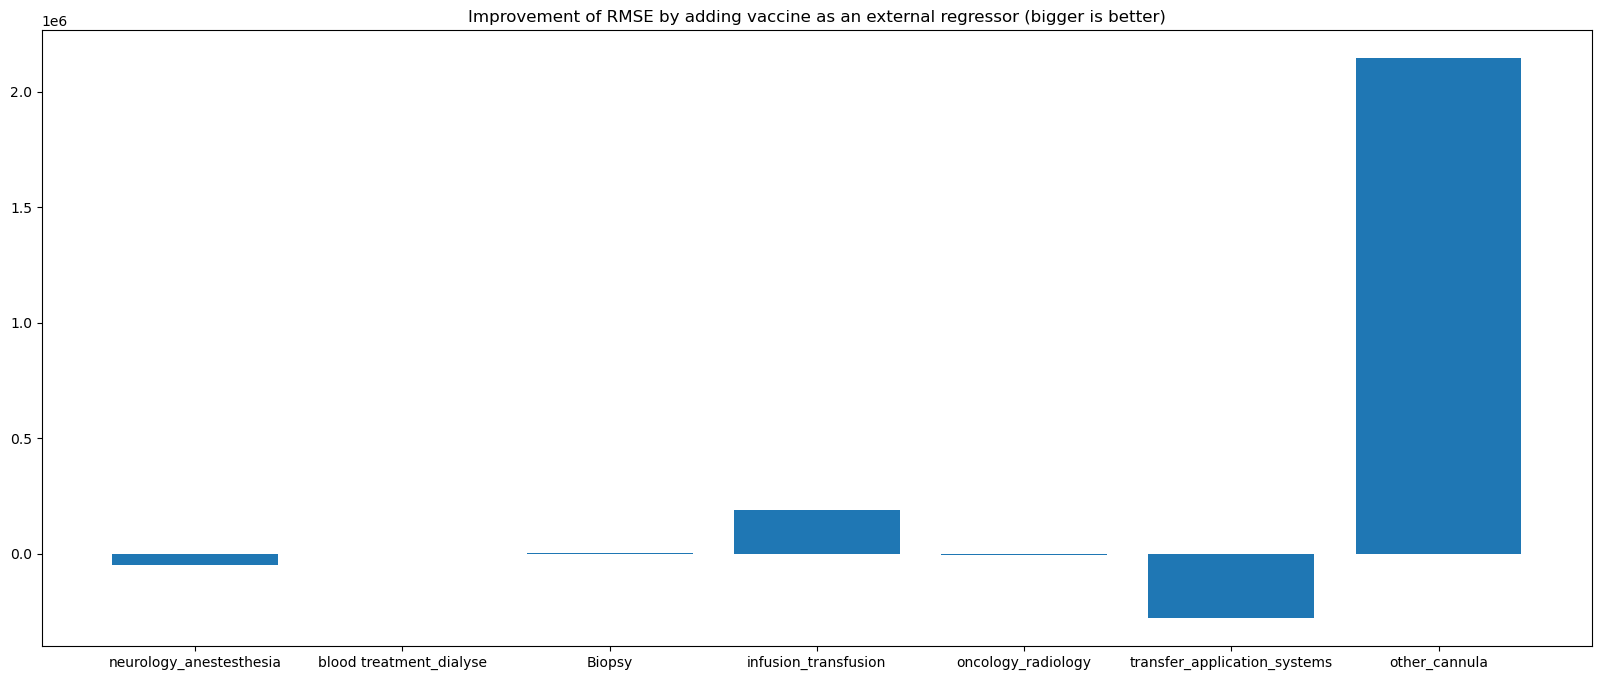

In [80]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.bar(range(len(col_categories)), list(col_categories.values()), align='center')

plt.xticks(range(len(col_categories)), list(col_categories.keys()));
ax.set_title("Improvement of RMSE by adding vaccine as an external regressor (bigger is better)")



### Examining the effect of external regressors on most positively affected component


The most affected component is `other_cannula`. Let's compare two prophet models both fit on `other_cannula`. The first one with vaccines as external regressor, the second one without.

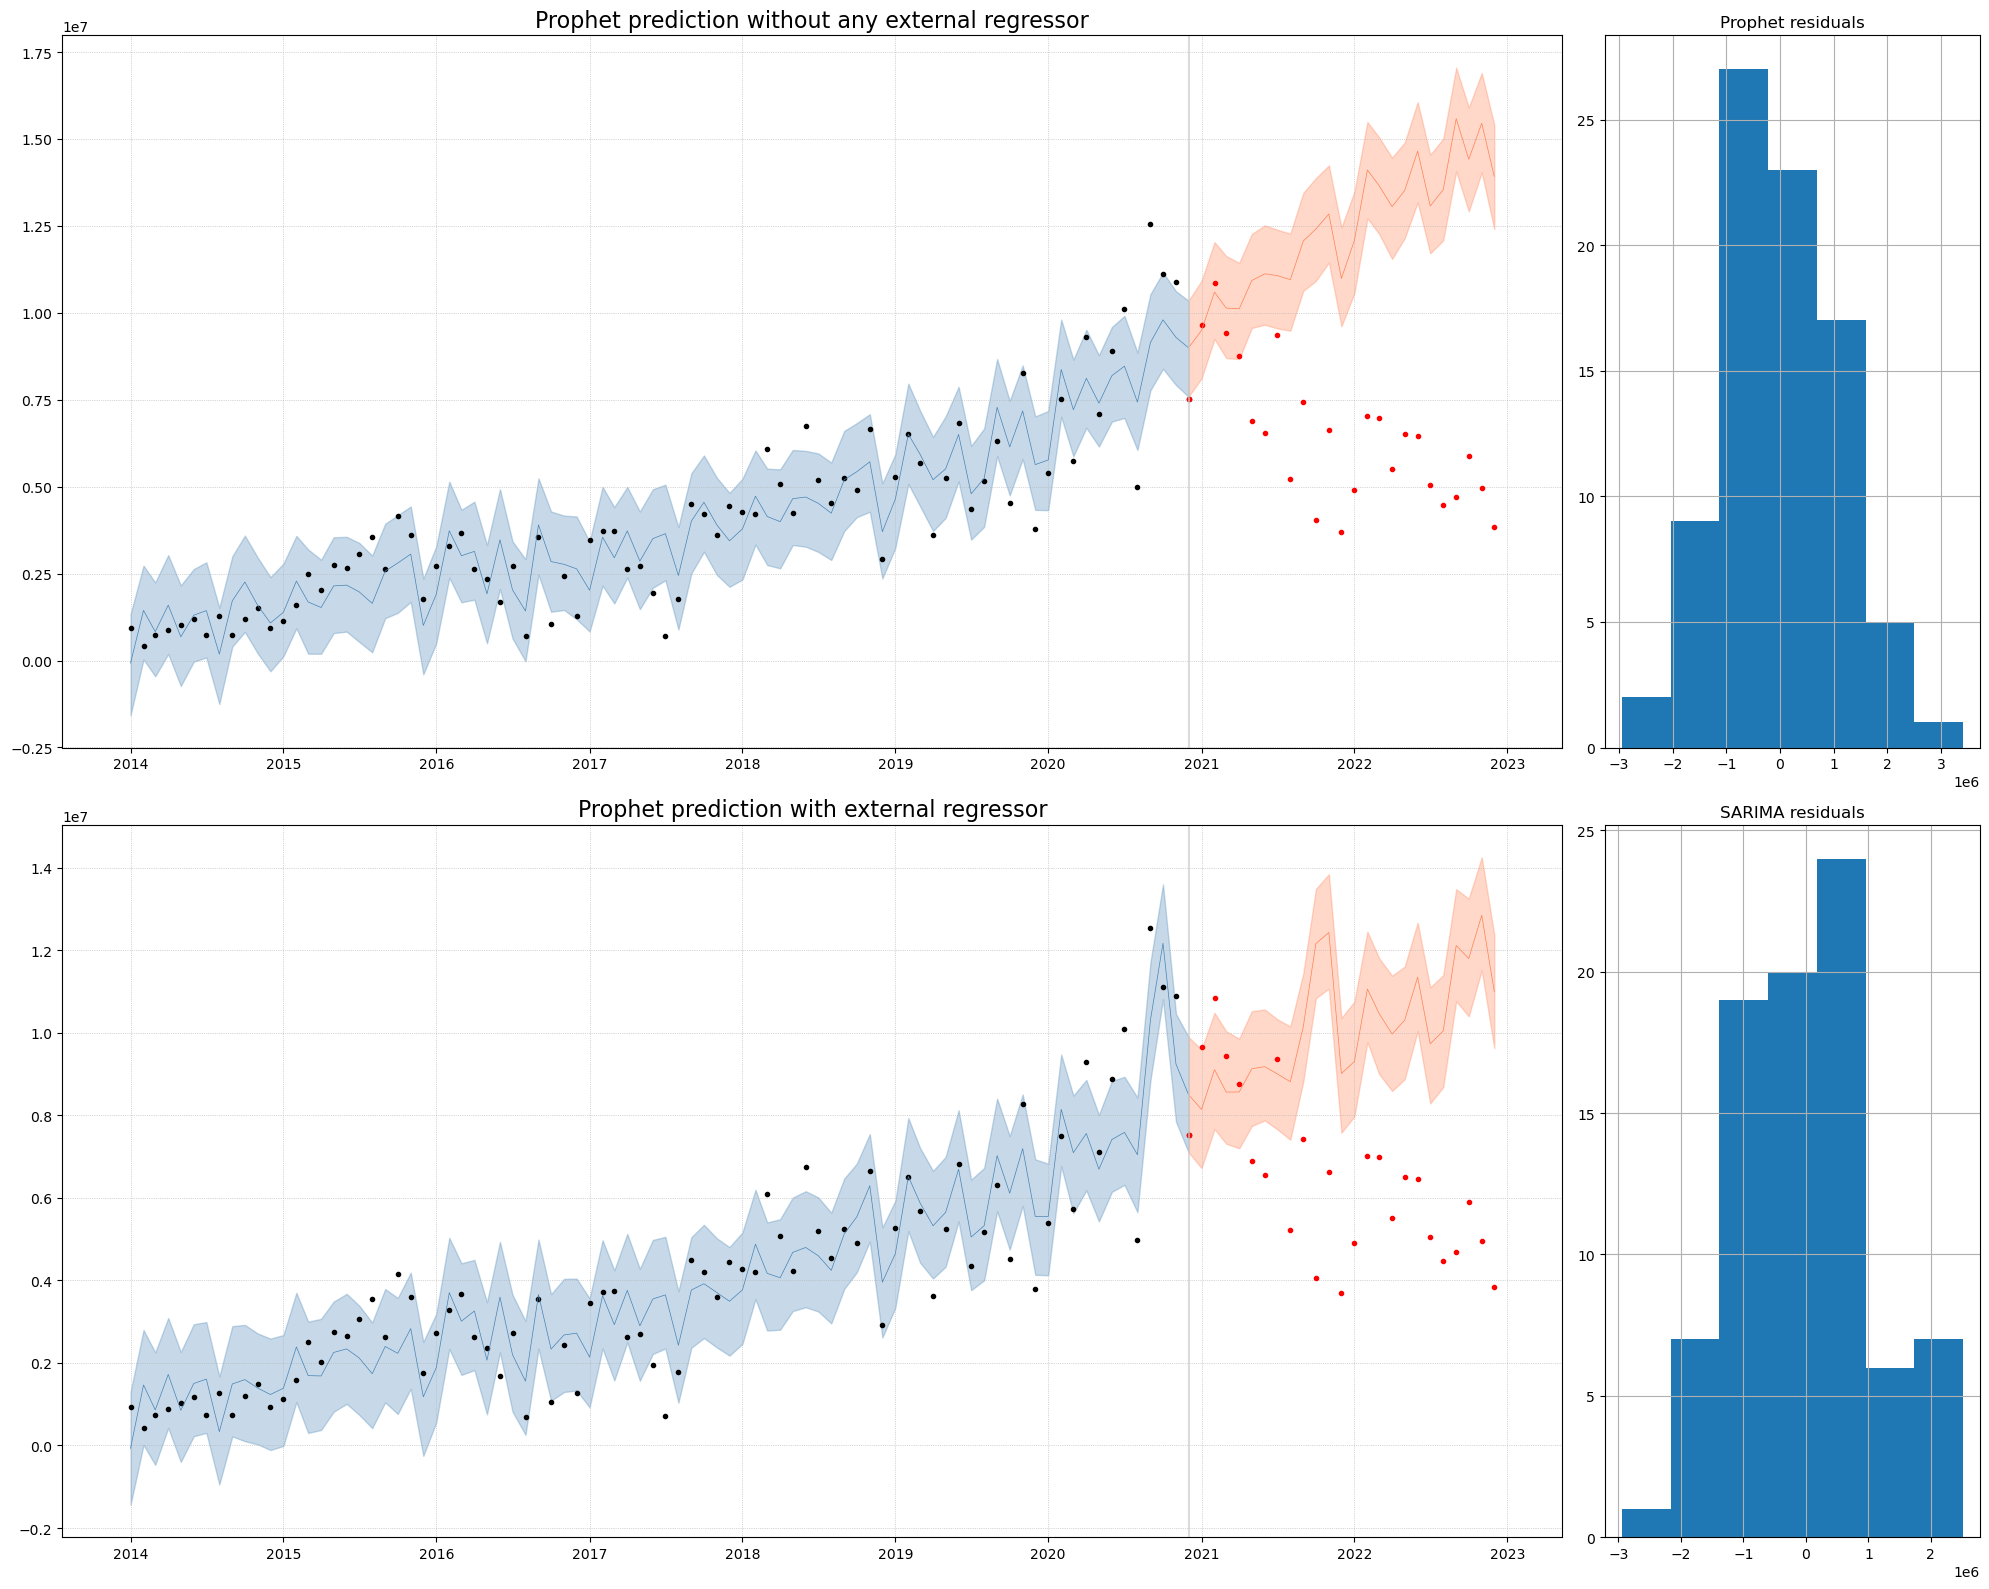

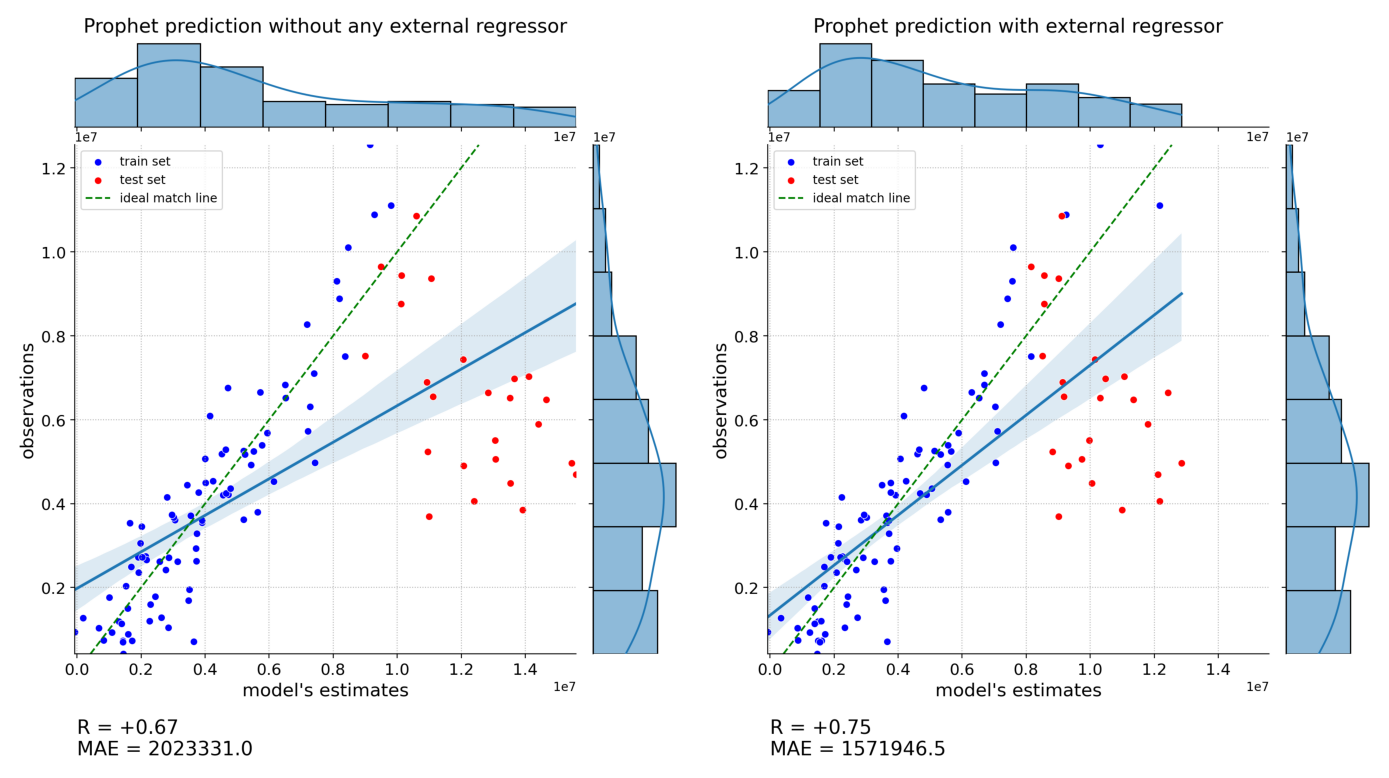

In [81]:
prophet_wo_model = pickle.load(open('other_canula_wo_regressor.model', 'rb'))
prophet_w_model = pickle.load(open('other_canula_w_regressor.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,M").set_index('Date')
df_sales= df_sales.rename(columns={'other_cannula' : 'Sales'})
df_sales.index = pd.to_datetime(df_sales.index)
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

viz_df = make_prophet_df(prophet_wo_model, prophet_w_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df, pred1='yhat1', pred1_lower='yhat1_lower',pred1_upper='yhat1_upper',pred2='yhat2',pred2_lower='yhat2_lower',pred2_upper='yhat2_upper', title1="Prophet prediction without any external regressor", title2="Prophet prediction with external regressor", text_offset=-2e6)

This is a great case to show how an external regressor can correct a faulty trend. In the training data (blue) the trend is clearly up and right at the test data, there is a reversal. The model has no way of knowing that the reversal happens, it will naturally follow the trend. However, the behavior of the vaccine time series does contradict the trend and influances a trend reversal. This ultimately results in the series being closer to the observed values, at least throughout 2021.

### Examining the effect of external regressors on a marginally affected component

Biopsy also shows a positive impact but much smaller than above. Here there is no obvious reason explaining how the external regressor improves accuracy... it just fits the time series slightly better.

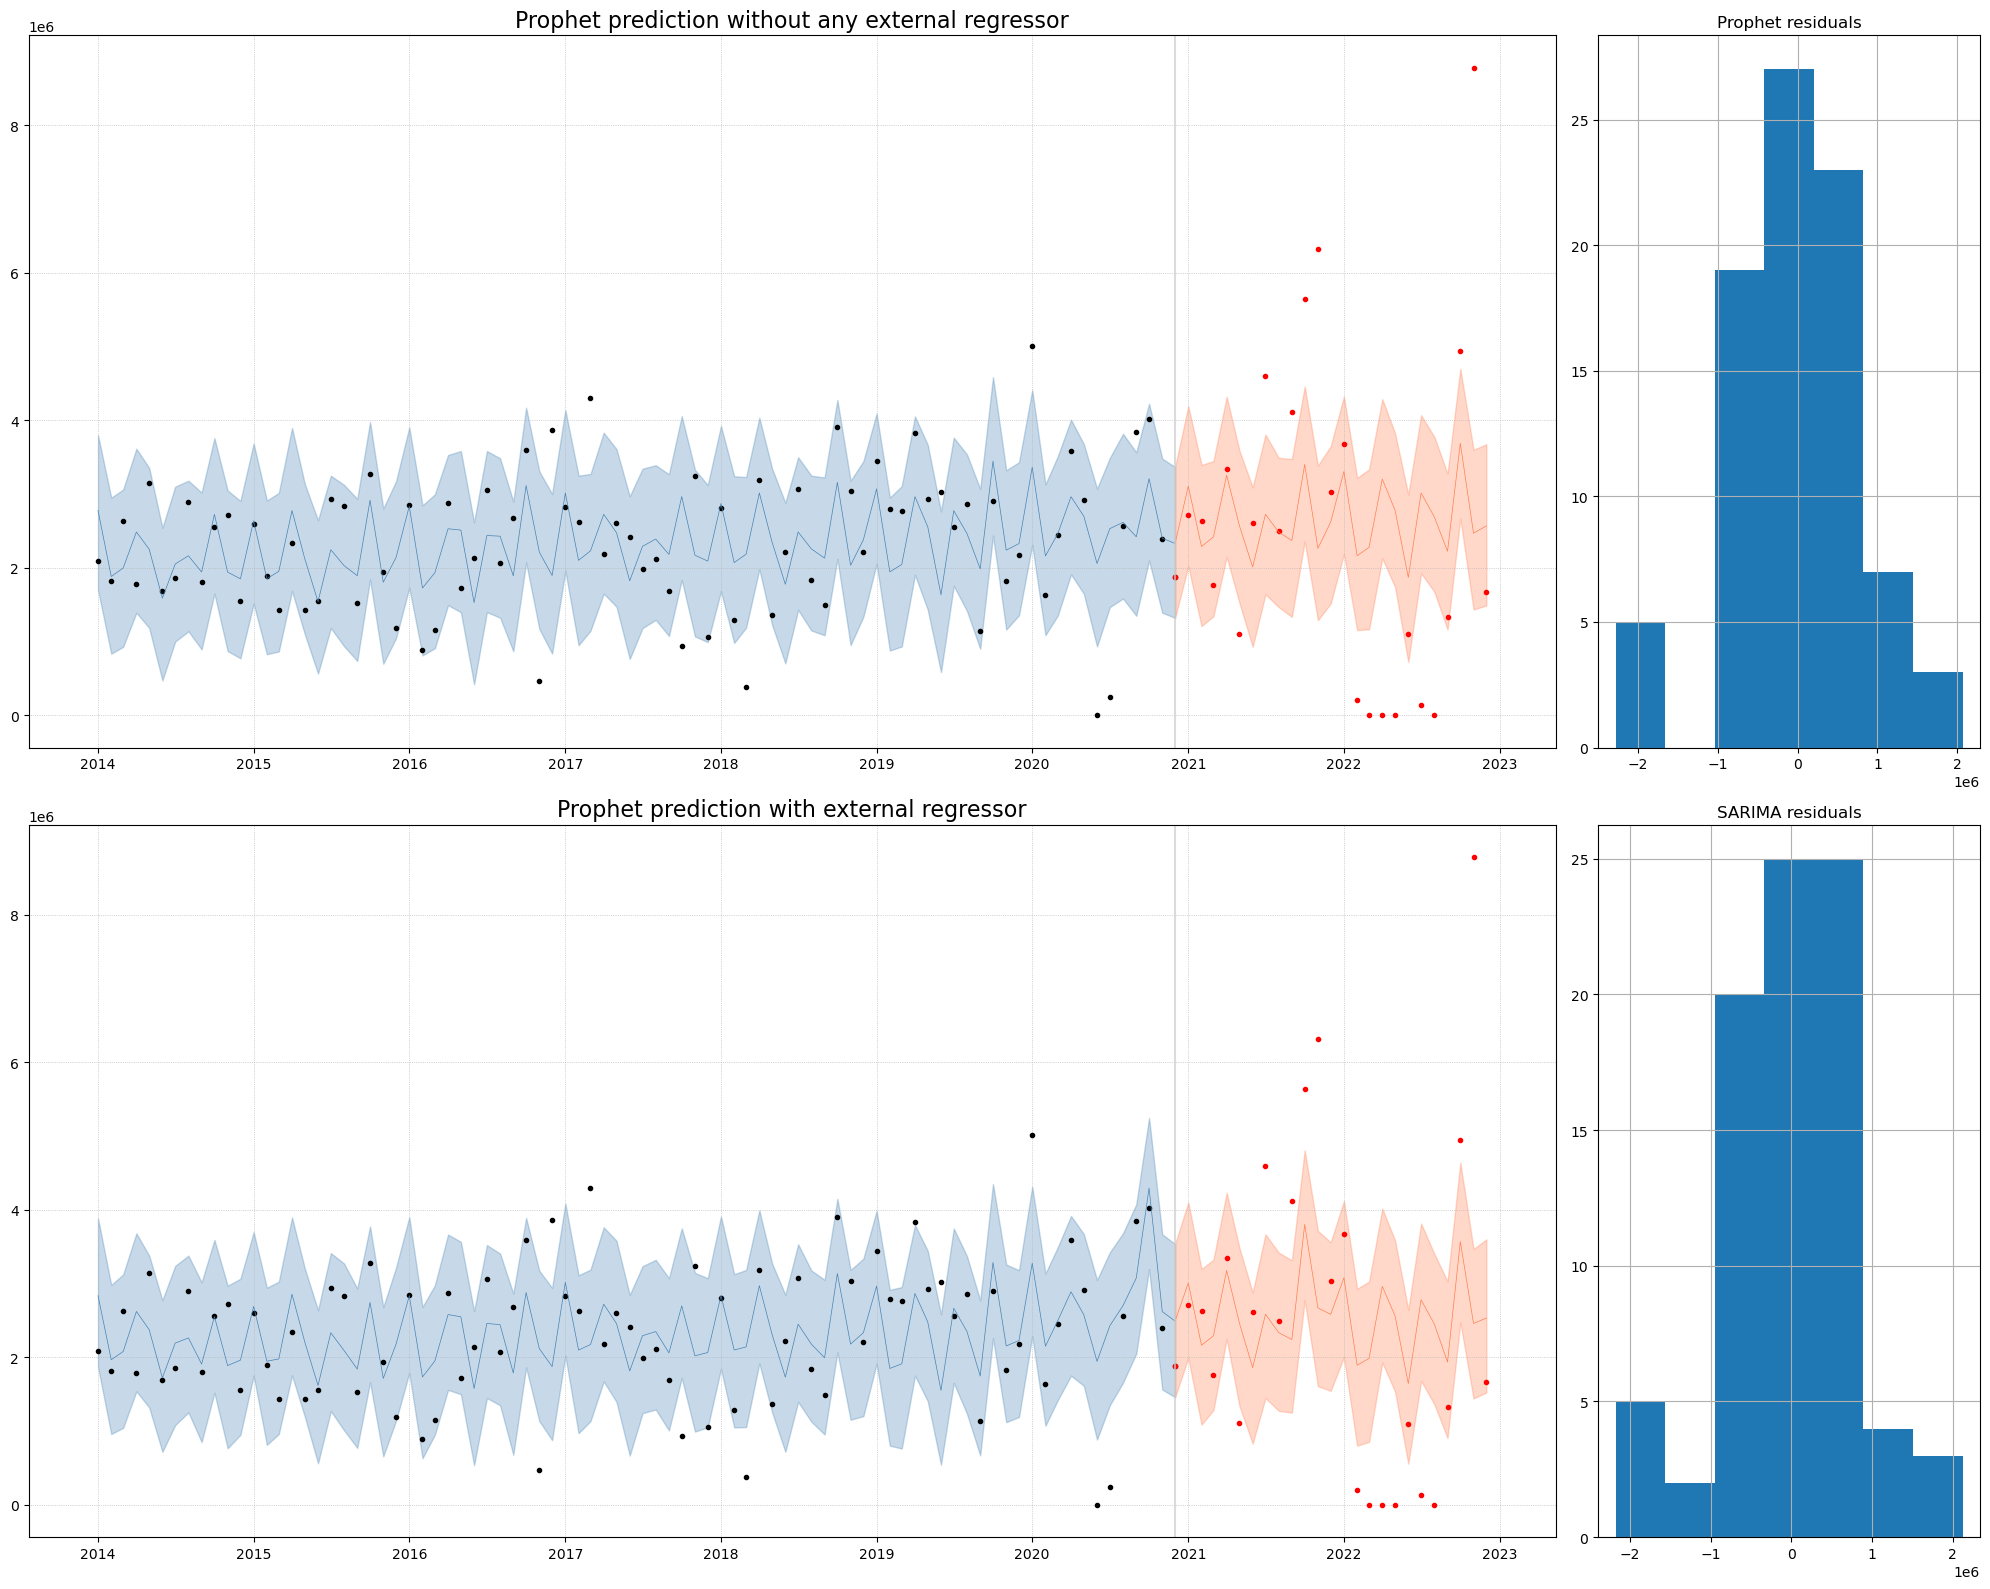

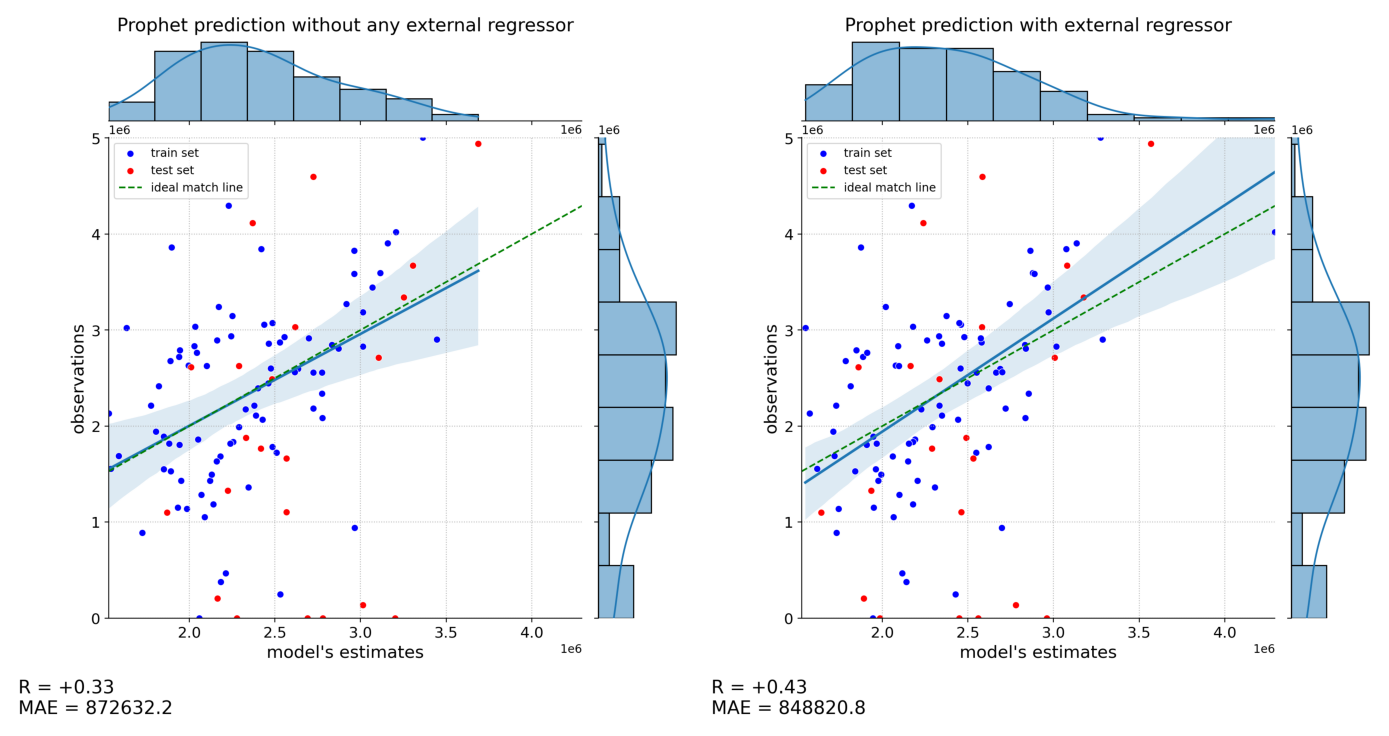

In [101]:
prophet_wo_model = pickle.load(open('biopsy_wo_regressor.model', 'rb'))
prophet_w_model = pickle.load(open('biopsy_w_regressor.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,I").set_index('Date')
df_sales= df_sales.rename(columns={'Biopsy' : 'Sales'})
df_sales.index = pd.to_datetime(df_sales.index)
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

viz_df = make_prophet_df(prophet_wo_model, prophet_w_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df, pred1='yhat1', pred1_lower='yhat1_lower',pred1_upper='yhat1_upper',pred2='yhat2',pred2_lower='yhat2_lower',pred2_upper='yhat2_upper', title1="Prophet prediction without any external regressor", title2="Prophet prediction with external regressor", text_offset=-1e6)

### Examining the effect of external regressors on most negatively affected component

From the bar chart above, the most negatively affected component is `transfer_application_systems`. Let's compare two prophet models both fit on `transfer_application_systems`. The first one with vaccines as external regressor, the second one without.

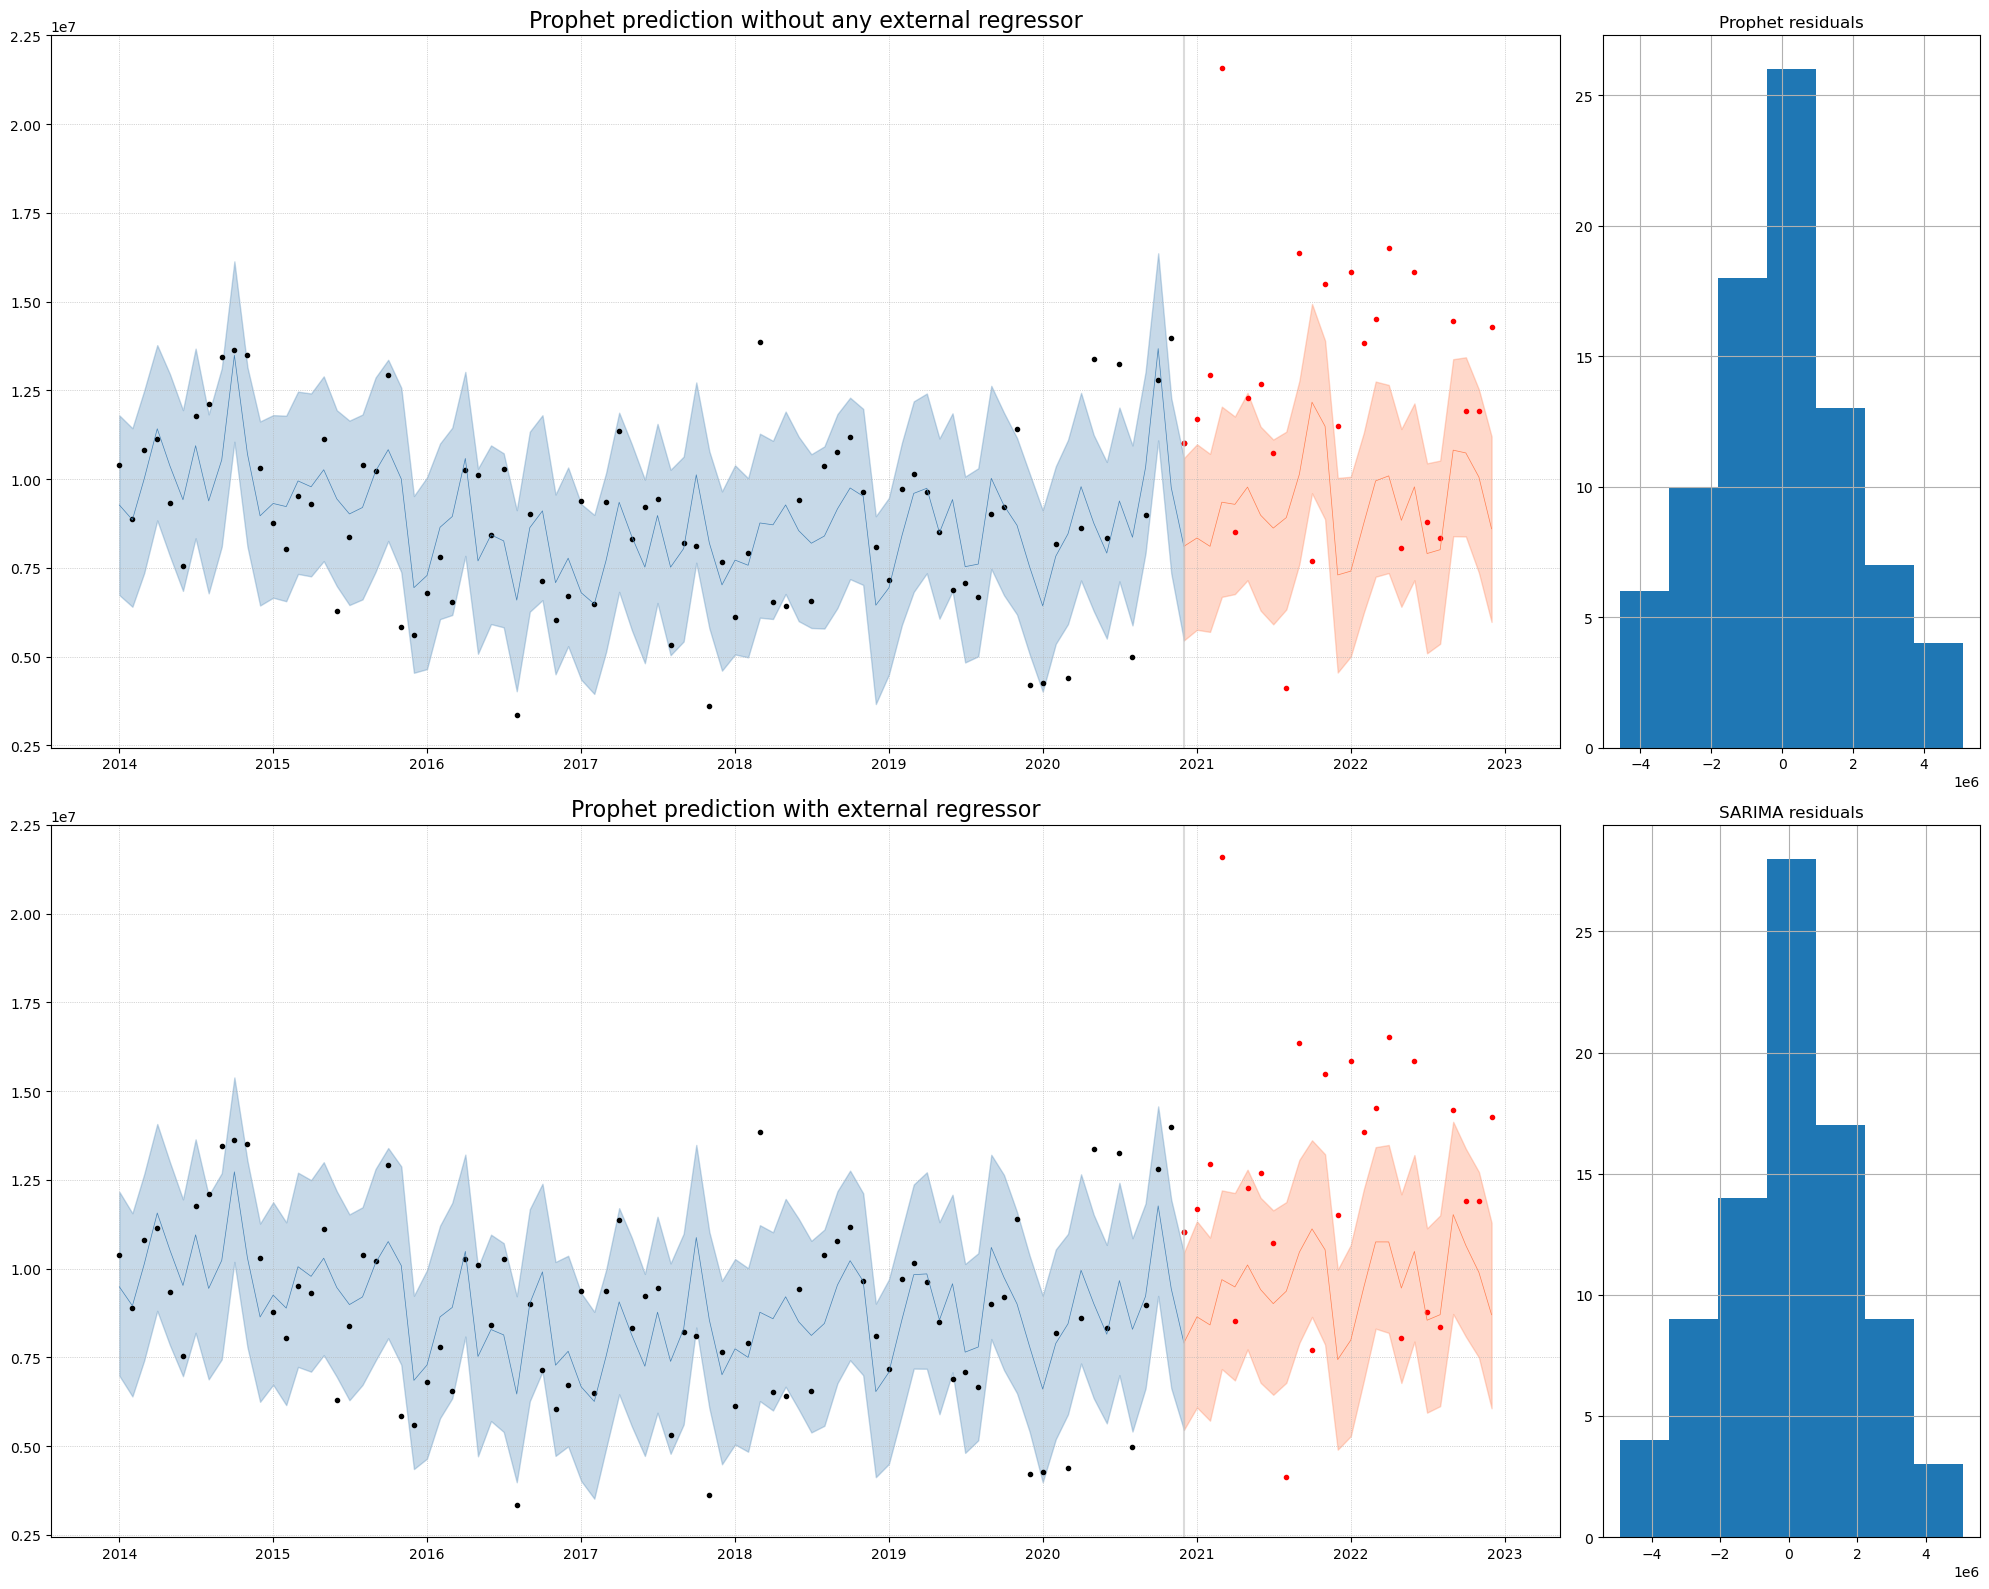

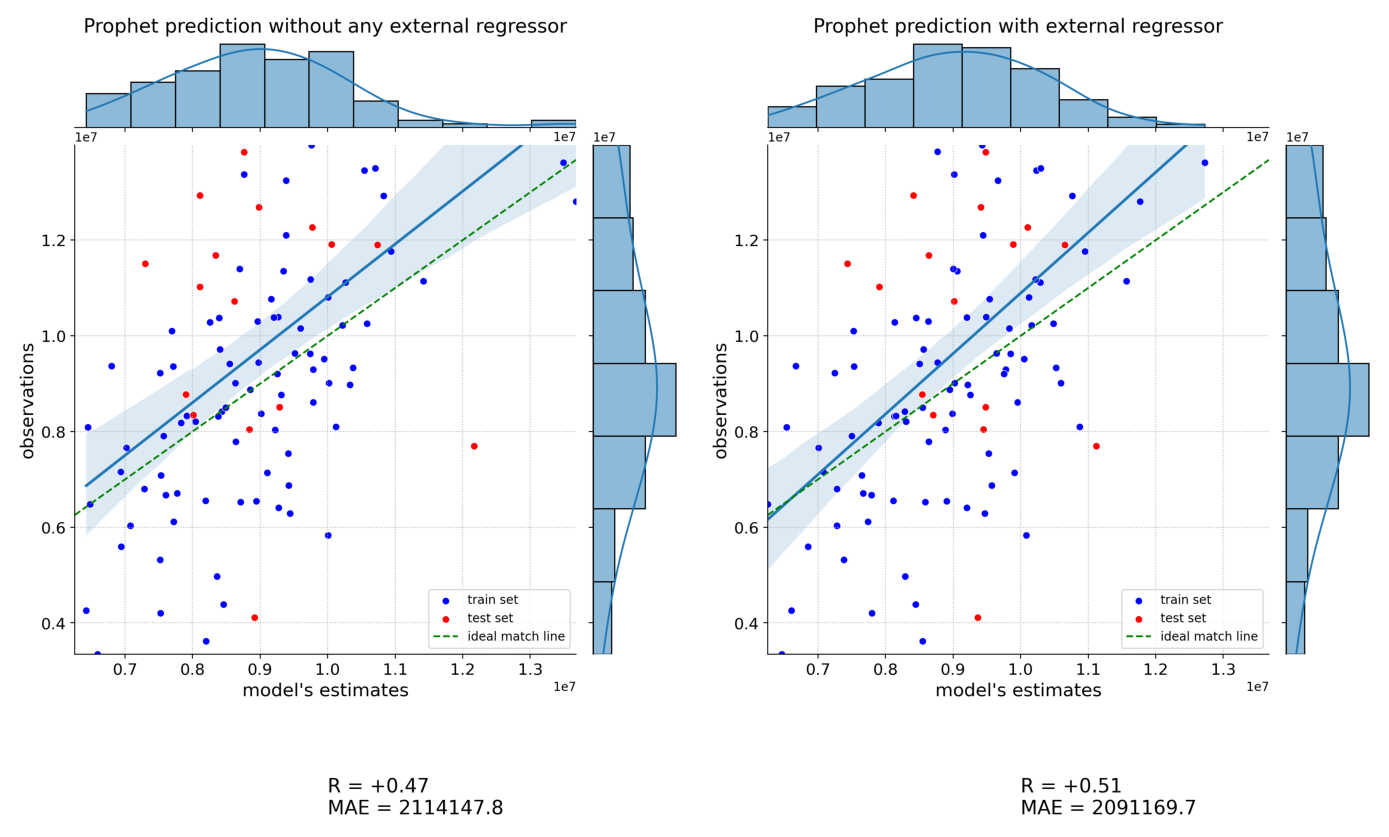

In [86]:
prophet_wo_model = pickle.load(open('transfer_application_systems_wo_regressor.model', 'rb'))
prophet_w_model = pickle.load(open('transfer_application_systems_w_regressor.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,L").set_index('Date')
df_sales= df_sales.rename(columns={'transfer_application_systems' : 'Sales'})
df_sales.index = pd.to_datetime(df_sales.index)
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

viz_df = make_prophet_df(prophet_wo_model, prophet_w_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df, pred1='yhat1', pred1_lower='yhat1_lower',pred1_upper='yhat1_upper',pred2='yhat2',pred2_lower='yhat2_lower',pred2_upper='yhat2_upper', title1="Prophet prediction without any external regressor", title2="Prophet prediction with external regressor", text_offset=0)

In this case, there is hardly any noticible undesirable effect of adding a regressor. While the RMSE decreases a little bit, a visual inspection yields to roughly the same result as well as a slightly improved MAE.

## Conclusion

Prophet with external regressors outperforms SARIMA methods by all metrics. It also preserves a smaller confidence interval allowing for predictions further in the future. After analyzing the effect of adding an external regressor on RMSE, it seems that individual components are either positively affected or not noticbly affected but never negatively affected.
Adding vaccine an external regressor to the model is therefore a good idea.
